In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm

In [2]:
path = ''
seed = 42
np.random.seed(seed)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
print(device)
def plot_curve(scores):
    plt.figure()
    plt.plot(scores)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('Evolution of score over episodes')



def plot_moving_average(episode_rewards, window_size, filename):
    moving_avg = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(10,5))
    plt.plot(moving_avg)
    plt.title(f"Moving Avg Over {window_size} episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Moving Average Score")

    plt.plot(episode_rewards, alpha=0.4)

    plt.axhline(y=np.mean(episode_rewards), color='r', linestyle='-', alpha=0.5)
    plt.legend(["Moving Average", "Scores"])
    plt.savefig(path + 'graphs/' + filename)
    plt.show()

cuda


In [4]:
class PPO_Storage():
    def __init__(self, bs):
        self.bs = bs
        self.clear()

    def generate(self):
        number_of_states = len(self.states)

        starting_batch = np.arange(0, number_of_states, self.bs)
        indices = np.arange(number_of_states)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.bs] for i in starting_batch]
        return np.array(self.states), np.array(self.actions), np.array(self.action_probabilities), np.array(self.rewards), np.array(self.values), np.array(self.done), batches



    def clear(self):
        self.actions = []
        self.states = []
        self.action_probabilities = []
        self.rewards = []
        self.values = []
        self.done = []

    def add(self, state, action, action_probability, value, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.action_probabilities.append(action_probability)
        self.values.append(value)
        self.rewards.append(reward)
        self.done.append(done)

In [5]:
class Actor_Critic_Network(nn.Module):
    def __init__(self, num_actions, lr):
        super(Actor_Critic_Network, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 8, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size = 2, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size = 2, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Flatten(start_dim=1)
        )
        self.softmax_layer = nn.Softmax(dim=-1)
        self.actor_classifier = nn.Linear(256, num_actions)
        self.critic_classifier = nn.Linear(256, 1)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.to(device)

    def forward(self, x):
        x = x / 255.0
        initial_computation = self.layers(x)
        distribution = self.actor_classifier(initial_computation)
        normalized_distribution = self.softmax_layer(distribution) 
        value = self.critic_classifier(initial_computation)
        return Categorical(normalized_distribution), value




In [6]:
class Agent():
    def __init__(self, epochs, bs, action_dim, gamma=0.99, lam=0.95, clip=0.20, lr=5e-5):
        self.gamma = gamma
        self.lam = lam
        self.clip = clip
        self.epochs = epochs
        self.actor_critic = Actor_Critic_Network(action_dim, lr)
        self.storage = PPO_Storage(bs)

    def memorize(self, state, action, action_probability, value, reward, done):
        self.storage.add(state, action, action_probability, value, reward, done)

    def choose_action(self, state):
        state = state.unsqueeze(0).float().to(device)
        distribution, val = self.actor_critic(state)
        action = distribution.sample()
        action_probability = torch.squeeze(distribution.log_prob(action)).item()
        action = torch.squeeze(action).item()
        val = torch.squeeze(val).item()
        return action, action_probability, val

    def advantage(self, rewards, values, dones):
        steps = len(rewards)
        adv = np.zeros(steps)
        for step in range(steps-1):
            current_discount = 1
            current_adv = 0
            for i in range(step, steps-1):
                if dones[i] == 1:
                    delta = rewards[i] - values[i]
                else:
                    delta = rewards[i] + self.gamma * values[i+1] - values[i]
                current_adv += delta * current_discount
                current_discount *= self.gamma * self.lam
            adv[step] = current_adv
        adv = torch.Tensor(adv).to(device)
        return adv


    def learning_step(self, critic_discount=0.5):
        for _ in range(self.epochs):
            states, actions, action_probs, values_list, rewards, dones, batches = self.storage.generate()
            advantages = self.advantage(rewards, values_list, dones)
            values = torch.Tensor(values_list).to(device)

            for batch in batches:
                state = torch.tensor(states[batch]).permute(0, 3, 1, 2).float().to(device)
                action_probabilities = torch.tensor(action_probs[batch]).to(device)
                action = torch.tensor(actions[batch]).to(device)

                new_action_distribution, critic_value = self.actor_critic(state)
                critic_value = torch.squeeze(critic_value)
                new_action_probs = new_action_distribution.log_prob(action)
                ratio = new_action_probs.exp() / action_probabilities.exp()
                weighted_probs = ratio * advantages[batch]
                clipped_probs = torch.clamp(ratio, 1-self.clip, 1+self.clip) * advantages[batch]
                actor_loss = -torch.min(weighted_probs, clipped_probs).mean()
                critic_loss = ((advantages[batch] + values[batch] - critic_value)**2).mean()
                total_loss = actor_loss + critic_discount * critic_loss

                self.actor_critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor_critic.optimizer.step()
        self.storage.clear()

    def save(self, filename):
        torch.save(self.actor_critic.state_dict(), path + 'models/' + filename)

    def load(self, filename):
        self.actor_critic.load_state_dict(torch.load(path + 'models/' + filename))
        print('Model has been loaded')



In [7]:
#Game Settings
# CoinRun, StarPilot, CaveFlyer, Dodgeball, Fruitbot, Chaser, Miner, Jumper, Leaper, Maze, BigFish, Heist, Climber, Plunder, Ninja, BossFight
game = "bigfish"
# Easy
background = True 
num_levels = 200
distr_mode = "easy"
# Hard
# num_levels = 500
# distr_mode = "hard"

# Model Settings
lr = 1e-4
episodes = 1600
epochs = 6
bs = 256
gamma = 0.99
lam = 0.95
clip = 0.2 
rollout_size = 1024
critic_discount = 0.5

# Environment
env = gym.make('procgen:procgen-'+ game +'-v0', 
                num_levels=num_levels, 
                start_level=seed, 
                rand_seed=seed, 
                distribution_mode=distr_mode,
                use_backgrounds=background,
                render_mode='rgb_array')
obs_space = env.observation_space.shape
number_of_actions = env.action_space.n

agent = Agent(epochs, bs, number_of_actions, gamma = gamma, lam = lam, clip = clip, lr=lr)
history = []
training_high_score = env.reward_range[0]
training_highest_last = env.reward_range[0]
last_saved = 0
window_size = episodes // 10
total_steps = 0
updates = 0
moving_avg = 0



TRAINING

In [315]:
bar = tqdm(range(episodes))

for i in bar:
    state = env.reset()
    done = False
    training_episode_score = 0
    while not done:
        action, action_probability, value = agent.choose_action(torch.Tensor(state).permute(2, 0, 1)) # Qui ha ancora 3 dimensioni perchè la quarta viene aggiunta dalla prima riga di choose_action
        next_state, score, done, _ = env.step(action)
        total_steps += 1
        training_episode_score += score
        agent.memorize(state, action, action_probability, value, score, done)
        if total_steps % rollout_size == 0:
            agent.learning_step(critic_discount)
        state = next_state
    history.append(training_episode_score)
    
    if i > window_size:
        moving_avg = np.mean(history[-window_size:])
        if moving_avg > training_highest_last:
            training_highest_last = moving_avg
            last_saved = i
            agent.save(f'model_checkpoint_{game}_{seed}_{lr}_{episodes}_{epochs}_{bs}_{gamma}_{lam}_{clip}_{rollout_size}_{critic_discount}.pth')
            updates += 1
    
    bar.set_description(f"Last Saved: {last_saved}, Best Moving Average (over {window_size} episodes): {training_highest_last:.4f}, Moving Average (last {window_size} episodes): {moving_avg:.4f}, Updates: {updates}, Global Avg Until Now: {np.mean(history):.4f}")
    if training_episode_score > training_high_score:
        training_high_score = training_episode_score
env.close()


  0%|          | 0/1600 [00:00<?, ?it/s]

(-inf, inf)
Highest Score:40.0
Avg Score:1.096875


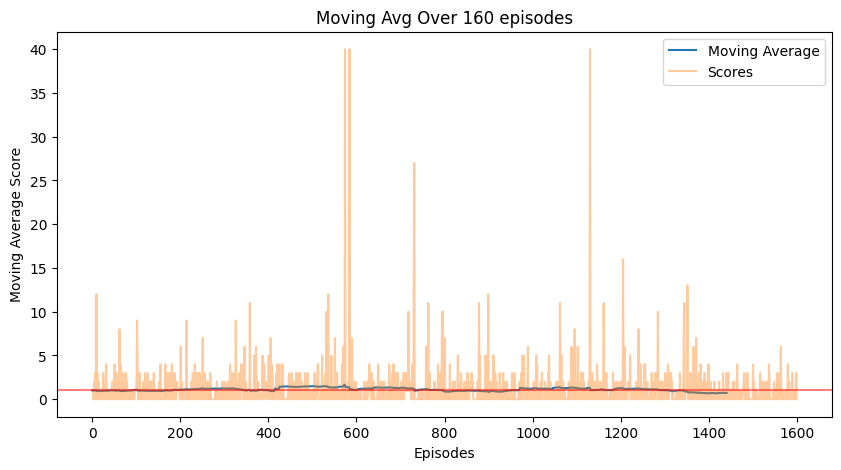

In [317]:
agent.save(f'model_checkpoint_{game}_{seed}_{lr}_{episodes}_{epochs}_{bs}_{gamma}_{lam}_{clip}_{rollout_size}_{critic_discount}_end_{i+1}.pth')
print(env.reward_range)
print(f'Highest Score:{training_high_score}')
print(f'Avg Score:{sum(history)/len(history)}')
plot_moving_average(history, window_size=window_size, filename = f'graph_{window_size}_{game}_{seed}_{lr}_{episodes}_{epochs}_{bs}_{gamma}_{lam}_{clip}_{rollout_size}_{critic_discount}.png')

In [318]:
print(total_steps)

267976


RANDOM TEST

In [319]:
testing_seed = 2024

testing_env = gym.make('procgen:procgen-'+ game +'-v0',
                        num_levels=0, 
                        start_level=testing_seed, 
                        rand_seed=testing_seed, 
                        distribution_mode=distr_mode,
                        use_backgrounds=background,
                        render_mode='rgb_array')

testing_history = []
testing_high_score = testing_env.reward_range[0]
random_history = []
random_high_score = testing_env.reward_range[0]


In [320]:

for i in tqdm(range((int(episodes/5)))):
    state = testing_env.reset()
    done = False
    random_episode_score = 0
    while not done:
        action = testing_env.action_space.sample()
        next_state, score, done, _ = testing_env.step(action)
        random_episode_score += score
        state = next_state
    random_history.append(random_episode_score)
    if random_episode_score > random_high_score:
        random_high_score = random_episode_score
testing_env.close()



  0%|          | 0/320 [00:00<?, ?it/s]

In [321]:
print(f'Random Highest Score:{random_high_score}')
print(f'Random Avg Score:{sum(random_history)/len(random_history)}')

Random Highest Score:9.0
Random Avg Score:0.865625


FULLY TRAINED AGENT TESTING

In [322]:
testing_env.reset()
for i in tqdm(range(int(episodes/5))):
    state = testing_env.reset()
    done = False
    testing_episode_score = 0
    while not done:
        action, action_probability, value = agent.choose_action(torch.Tensor(state).permute(2, 0, 1)) # Qui ha ancora 3 dimensioni perchè la quarta viene aggiunta dalla prima riga di choose_action
        next_state, score, done, _ = testing_env.step(action)
        testing_episode_score += score
        agent.memorize(state, action, action_probability, value, score, done)
        state = next_state
    testing_history.append(testing_episode_score)
    if testing_episode_score > testing_high_score:
        testing_high_score = testing_episode_score
testing_env.close()

  0%|          | 0/320 [00:00<?, ?it/s]

In [323]:
print(f'Testing Highest Score:{testing_high_score}')
print(f'Testing Avg Score:{sum(testing_history)/len(testing_history)}')

Testing Highest Score:10.0
Testing Avg Score:0.884375


BEST SCORING AGENT TESTING

In [ ]:
testing_env.reset()
testing_history = []
testing_high_score = testing_env.reward_range[0]

# Loading the best model
agent.load(f'model_checkpoint_{game}_{seed}_{lr}_{episodes}_{epochs}_{bs}_{gamma}_{lam}_{clip}_{rollout_size}_{critic_discount}.pth')

In [325]:
for i in tqdm(range(int(episodes/5))):
    state = testing_env.reset()
    done = False
    testing_episode_score = 0
    while not done:
        action, action_probability, value = agent.choose_action(torch.Tensor(state).permute(2, 0, 1)) # Qui ha ancora 3 dimensioni perchè la quarta viene aggiunta dalla prima riga di choose_action
        next_state, score, done, _ = testing_env.step(action)
        testing_episode_score += score
        agent.memorize(state, action, action_probability, value, score, done)
        state = next_state
    testing_history.append(testing_episode_score)
    if testing_episode_score > testing_high_score:
        testing_high_score = testing_episode_score
testing_env.close()

  0%|          | 0/320 [00:00<?, ?it/s]

In [326]:
print(f'Testing Highest Score on best model:{testing_high_score}')
print(f'Testing Avg Score on best model:{sum(testing_history)/len(testing_history)}')


Testing Highest Score on best model:40.0
Testing Avg Score on best model:2.85
